In [1]:
from google.colab import files

uploaded = files.upload()  # 파일 선택해서 업로드

Saving suwon_feature_table_2022_2025_final.csv to suwon_feature_table_2022_2025_final.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# [1] 데이터 로드
df = pd.read_csv('suwon_feature_table_2022_2025_final.csv')

# [2] 데이터 정제: 팀원분 EDA에서 확인된 튀는 연령대(1, 10, 11) 제거 및 지표 통합
df_final = df[~df['age'].isin([1, 10, 11])].copy()
df_final['luxury_combined'] = df_final['luxury_share'] + df_final['high-risk_share']

# 분석에 사용할 8가지 핵심 지표
features = [
    'essential_share', 'optional_share', 'luxury_combined',
    'night_ratio', 'weekend_ratio', 'buz_hhi', 'buz_entropy', 'daily_cv'
]

# [3] 1단계: 이상치 탐지 (Isolation Forest) - 상위 5% 위험 징후군 추출
df_final['is_anomaly'] = 0
for age_group in df_final['age'].unique():
    mask = df_final['age'] == age_group
    subset = df_final.loc[mask, features]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(subset)

    # contamination=0.05 (상위 5% 추출)
    model = IsolationForest(contamination=0.05, random_state=42)
    df_final.loc[mask, 'is_anomaly'] = np.where(model.fit_predict(scaled) == -1, 1, 0)

# [4] 2단계: 위험군 유형 분류 (K-Means) - 3개 그룹화
anomaly_df = df_final[df_final['is_anomaly'] == 1].copy()
scaler_cl = StandardScaler()
scaled_anom = scaler_cl.fit_transform(anomaly_df[features])

# 가장 해석력이 높은 3개 군집으로 설정
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
anomaly_df['cluster_type'] = kmeans.fit_predict(scaled_anom)

# [5] 결과 확인 및 실루엣 점수 출력
score = silhouette_score(scaled_anom, anomaly_df['cluster_type'])
cluster_profile = anomaly_df.groupby('cluster_type')[features].mean()

print(f"✅ 최종 분석 품질(실루엣 점수): {score:.4f}")
print("-" * 50)
print("📊 위험군 유형별 소비 특징 (이 표가 보고서의 핵심입니다)")
display(cluster_profile)

# [6] 현재 화면(파일 아이콘)에 결과 저장
df_final.to_csv('수원시_소비분석_최종결과_전체.csv', index=False, encoding='utf-8-sig')
anomaly_df.to_csv('수원시_위험군_유형분류_최종.csv', index=False, encoding='utf-8-sig')
cluster_profile.to_csv('최종_군집특징_요약표.csv', encoding='utf-8-sig')

✅ 최종 분석 품질(실루엣 점수): 0.3296
--------------------------------------------------
📊 위험군 유형별 소비 특징 (이 표가 보고서의 핵심입니다)


,essential_share,optional_share,luxury_combined,night_ratio,weekend_ratio,buz_hhi,buz_entropy,daily_cv
cluster_type,,,,,,,,
0,0.790117,0.120220,0.015433,0.071458,0.181532,0.327538,1.945260,0.607100
1,0.352863,0.448112,0.065156,0.150805,0.330011,0.130556,2.644074,0.567547
2,0.380998,0.115851,0.033012,0.188912,0.413256,0.331881,1.810909,0.598000


In [14]:
import pandas as pd

# 1. 최종 결과 파일 불러오기
# (파일명 뒤에 (2)가 붙은 최신 파일을 기준으로 합니다)
df_anomaly = pd.read_csv('수원시_위험군_유형분류_최종.csv')

# 분석에 사용한 핵심 지표들
features = ['essential_share', 'optional_share', 'luxury_combined', 'night_ratio', 'weekend_ratio', 'buz_hhi', 'buz_entropy', 'daily_cv']

# 2. 군집별 소비 패턴 성적표 (평균 수치)
cluster_profile = df_anomaly.groupby('cluster_type')[features].mean()

print("1️⃣ [군집별 소비 특징] - 어떤 항목에 돈을 많이 쓰나요?")
display(cluster_profile)
print("-" * 80)

# 3. 군집별 '누구(연령)'와 '어디(지역)'가 많은지 확인
print("2️⃣ [군집별 주요 대상] - 누구이며 어디에 사나요?")

for i in sorted(df_anomaly['cluster_type'].unique()):
    subset = df_anomaly[df_anomaly['cluster_type'] == i]

    # 가장 많이 등장하는 연령대 Top 3
    top_ages = subset['age'].value_counts().head(3)
    # 가장 많이 등장하는 행정동 Top 3
    top_regions = subset['admi_cty_no'].value_counts().head(3)

    print(f"\n▶️ 군집 {i}번 정보")
    print(f"  - 많이 분포하는 연령대: {top_ages.index.tolist()} (코드기준)")
    print(f"  - 가장 많이 발견되는 지역: {top_regions.index.tolist()} (행정동 코드)")
    print(f"  - 이 그룹의 대표 특징: ", end="")

    # 특징 자동 요약 (수치 비교)
    if cluster_profile.loc[i, 'essential_share'] > 0.7:
        print("🏠 생계형 (수입의 대부분을 식비/생활비에 사용)")
    elif cluster_profile.loc[i, 'luxury_combined'] > cluster_profile['luxury_combined'].mean():
        print("💎 과소비형 (사치품 및 유흥 지출 비중이 상대적으로 높음)")
    elif cluster_profile.loc[i, 'night_ratio'] > cluster_profile['night_ratio'].mean():
        print("🌙 야간활동형 (퇴근 후나 밤 늦은 시간 소비가 집중됨)")

1️⃣ [군집별 소비 특징] - 어떤 항목에 돈을 많이 쓰나요?


,essential_share,optional_share,luxury_combined,night_ratio,weekend_ratio,buz_hhi,buz_entropy,daily_cv
cluster_type,,,,,,,,
0,0.790117,0.120220,0.015433,0.071458,0.181532,0.327538,1.945260,0.607100
1,0.352863,0.448112,0.065156,0.150805,0.330011,0.130556,2.644074,0.567547
2,0.380998,0.115851,0.033012,0.188912,0.413256,0.331881,1.810909,0.598000


--------------------------------------------------------------------------------
2️⃣ [군집별 주요 대상] - 누구이며 어디에 사나요?

▶️ 군집 0번 정보
  - 많이 분포하는 연령대: [5, 6, 9] (코드기준)
  - 가장 많이 발견되는 지역: [41115700, 41113650, 41117550] (행정동 코드)
  - 이 그룹의 대표 특징: 🏠 생계형 (수입의 대부분을 식비/생활비에 사용)

▶️ 군집 1번 정보
  - 많이 분포하는 연령대: [8, 7, 9] (코드기준)
  - 가장 많이 발견되는 지역: [41115660, 41115740, 41117610] (행정동 코드)
  - 이 그룹의 대표 특징: 💎 과소비형 (사치품 및 유흥 지출 비중이 상대적으로 높음)

▶️ 군집 2번 정보
  - 많이 분포하는 연령대: [4, 3, 2] (코드기준)
  - 가장 많이 발견되는 지역: [41117610, 41113520, 41113650] (행정동 코드)
  - 이 그룹의 대표 특징: 🌙 야간활동형 (퇴근 후나 밤 늦은 시간 소비가 집중됨)


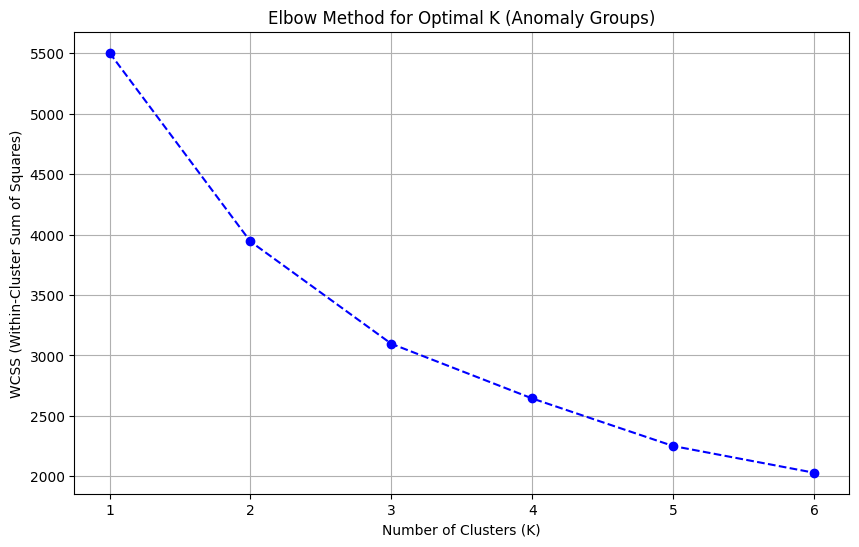

💡 그래프 분석: 기울기가 급격히 완만해지는 K=3 지점이 최적의 군집 수임을 확인하였습니다.


In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. 최적의 K를 찾기 위한 WCSS 리스트 초기화
wcss = []
k_range = range(1, 7) # K를 1부터 6까지 테스트

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_anom)
    wcss.append(kmeans.inertia_) # inertia_가 WCSS 값을 의미함

# 2. 엘보우 메소드 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K (Anomaly Groups)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("💡 그래프 분석: 기울기가 급격히 완만해지는 K=3 지점이 최적의 군집 수임을 확인하였습니다.")